# Divergence: Analysis of Forecast Bias in the EIA-930 Dataset

This notebook analyzes the distribution of forecast biases in the EIA-930 dataset. The goal is to establish a baselien value against which we can measure if future scenarios of 
load from the TELL model have "meaningfully" diverged from one another.

In [2]:
# Start by importing the packages we need:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from glob import glob


## Set the Directory Structure

In [3]:
# Identify the data input and output directories:
data_input_dir =  '/Users/burl878/Documents/Research/IMMM/Data/TELL_Input_Data/tell_quickstarter_data/outputs/historical_ba_load/'
data_output_dir =  '/Users/burl878/Documents/code_repos/exp_group_b_test/analyses/data/'
image_output_dir =  '/Users/burl878/Documents/code_repos/exp_group_b_test/analyses/plots/forecast_bias/'

# If the "image_output_dir" subdirectory doesn't exist then create it:
if not os.path.exists(image_output_dir):
   os.makedirs(image_output_dir)


## Process the EIA-930 Dataset

In [47]:
# Create a list of all files in the input directory:
list_of_files = glob(f'{data_input_dir}*.csv')

# Loop over the list of files and extract the forecast bias time series for each BA:
for file in range(len(list_of_files)):
    # Read in the .csv file:
    ba_df = pd.read_csv(list_of_files[file])
    
    # Rename the columns for simplicity:
    ba_df.rename(columns={'Forecast_Demand_MWh': 'Forecast_MWh',
                          'Adjusted_Demand_MWh': 'Demand_MWh'}, inplace=True)
    
    # Subset to only the years from 2016 to 2019:
    ba_df = ba_df.loc[(ba_df['Year'] >= 2016) & (ba_df['Year'] <= 2019)]
    
    # Subset to only rows without NaNs for the forecast and adjusted demand:
    ba_df = ba_df[(~ba_df['Forecast_MWh'].isnull()) & (~ba_df['Demand_MWh'].isnull())]
    
    # Calculate the absolute forecast bias:
    #ba_df['Absolute_Bias_MWh'] = abs(ba_df['Demand_MWh'] - ba_df['Forecast_MWh'])
    ba_df['Absolute_Bias_MWh'] = ba_df['Demand_MWh'] - ba_df['Forecast_MWh']
    
    # Calculate the relative forecast bias:
    ba_df['Relative_Bias_%'] = 100*(ba_df['Absolute_Bias_MWh']/ba_df['Demand_MWh']).round(4)
    
    # Only keep the columns that are needed:
    ba_df = ba_df[['Demand_MWh', 'Forecast_MWh', 'Absolute_Bias_MWh', 'Relative_Bias_%']].copy()
    
    # Concatenate the bias time series across BAs:
    if file == 0:
       output_df = ba_df.copy()
    else:
       output_df = pd.concat([output_df, ba_df])
    
    del ba_df
    
# Replace infinite data with NaN:
output_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values:
output_df.dropna(inplace=True)

# Drop rows with biases greater than 50%:
output_df = output_df.loc[(output_df['Relative_Bias_%'] <= 50) & (output_df['Relative_Bias_%'] >= -50)]

# Calculate the mean and standard deviation of the bias time series:
bias_mean = output_df['Relative_Bias_%'].mean()
bias_std = output_df['Relative_Bias_%'].std()
print(('Mean = ' + str(bias_mean.round(2)) + '%'))
print(('Standard Deviation = ' + str(bias_std.round(2)) + '%'))

# Return the output as a dataframe:
output_df


Mean = -0.02%
Standard Deviation = 8.69%


,Demand_MWh,Forecast_MWh,Absolute_Bias_MWh,Relative_Bias_%
4408,3254.0,3373.0,-119.0,-3.66
4409,3472.0,3561.0,-89.0,-2.56
4410,3448.0,3576.0,-128.0,-3.71
4411,3417.0,3559.0,-142.0,-4.16
4412,3374.0,3513.0,-139.0,-4.12
...,...,...,...,...
39470,52.0,52.0,0.0,0.00
39471,52.0,52.0,0.0,0.00
39472,50.0,50.0,0.0,0.00
39473,50.0,50.0,0.0,0.00


## Make the Plot

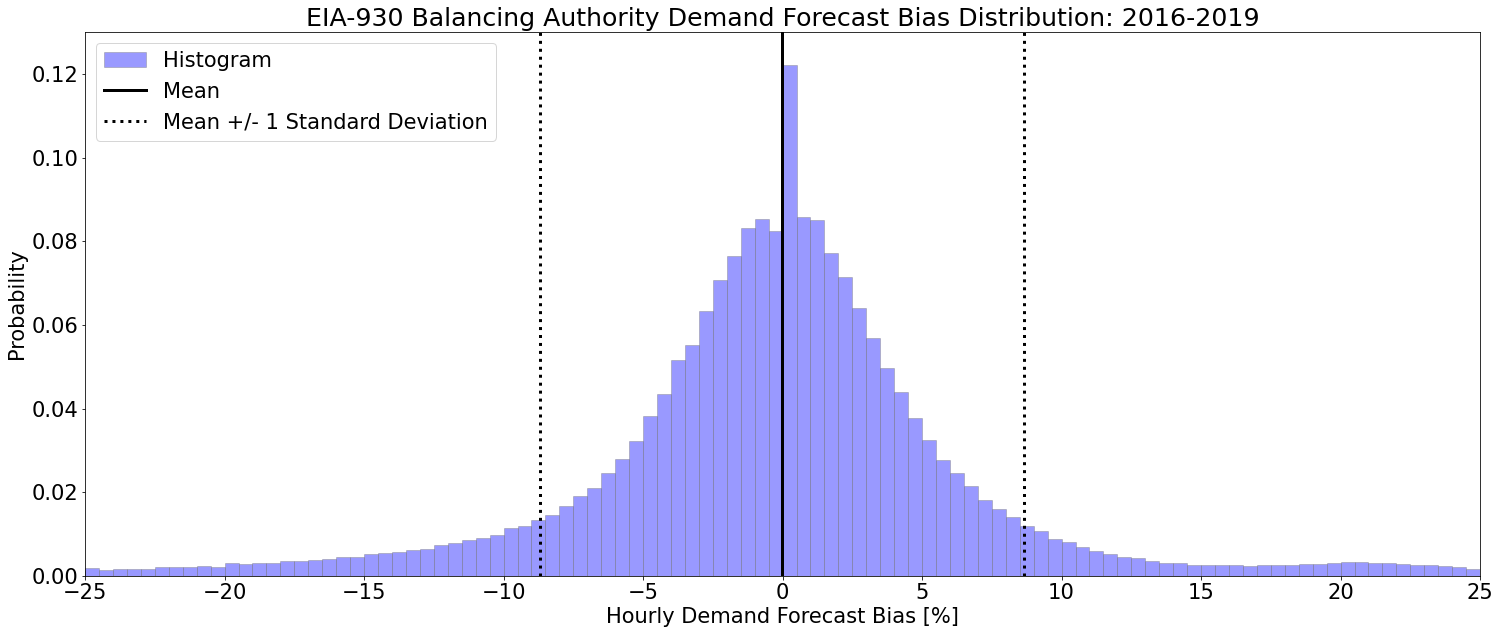

In [46]:
# Make the plot:
plt.figure(figsize=(25, 10))
plt.rcParams['font.size'] = 21
n, bins, patches = plt.hist(output_df['Relative_Bias_%'], 200, density=True, facecolor='b', edgecolor='gray', alpha=0.4, label='Histogram')
plt.plot([bias_mean, bias_mean], [0, 1], color='k', linestyle='-', label='Mean', linewidth=3)
plt.plot([(bias_mean - bias_std), (bias_mean - bias_std)], [0, 1], color='k', linestyle=':', label='Mean +/- 1 Standard Deviation', linewidth=3)
plt.plot([(bias_mean + bias_std), (bias_mean + bias_std)], [0, 1], color='k', linestyle=':', linewidth=3)
plt.xlim(-25, 25)
plt.ylim(0, 0.13)
plt.xticks([-25,-20,-15,-10,-5,0,+5,+10,+15,+20,+25])
plt.legend(loc='upper left')
plt.xlabel('Hourly Demand Forecast Bias [%]')
plt.ylabel('Probability')
plt.title('EIA-930 Balancing Authority Demand Forecast Bias Distribution: 2016-2019')

filename = ('Load_Forecast_Bias_Distribution.png')
plt.savefig(os.path.join(image_output_dir, filename), dpi=300, bbox_inches='tight', facecolor='white')
